In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14,5]

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
import xesmf as xe

In [2]:
encoding={'ts':{'dtype':'float32'},'lon':{'dtype':'float32'},'lat':{'dtype':'float32'}}

In [3]:
def load_dataset(url,start_year):
    ds = xr.open_dataset(url,decode_times=False)
    if 'T' in ds.coords:
        ds = ds.rename({'T':'time'})
    if 'X' in ds.coords:
        ds = ds.rename({'X':'lon','Y':'lat'})
    if 'longitude' in ds.coords:
        ds = ds.rename({'longitude':'lon','latitude':'lat'})
    if 'sst' in ds.data_vars:
        ds = ds.rename({'sst':'ts'})
    # make lon 0 to 360 
    ds.coords['lon'] = np.mod(ds['lon'], 360)
    ds = ds.reindex({ 'lon' : np.sort(ds['lon'])})
    # make lat increasing
    ds = ds.sortby('lat')
    ds['time'] = pd.date_range('01/01/'+str(start_year), periods=len(ds.time), freq='MS').shift(15, freq='D') 
    return ds

In [4]:
def linregress_1d(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

def linregress_xr(da,dim='time'):
    NT = len(da[dim])
    da[dim] = np.arange(0,NT) 
    stats = xr.apply_ufunc(linregress_1d, da[dim], da,
                           input_core_dims=[[dim], [dim]],
                           output_core_dims=[["parameter"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float32'],
                           output_sizes={"parameter": 5},
                          ) 
    ds = ((NT-1)*stats[:,:,0]).to_dataset(name='trend')
    ds['pvalue'] = stats[:,:,3]
    return ds

In [32]:
def plot_TP(ds, name):
    alpha = 0.05
    fig, axs = plt.subplots(figsize=(9, 6))

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180));

    cm = plt.get_cmap("RdYlBu_r")
    an_image = ds.trend.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                vmin=-1.5, vmax=1.5, cmap=cm, add_colorbar=False, rasterized=True);
    cbar = plt.colorbar(an_image, shrink=0.5, pad=.03)
    cbar.set_label(r'SST trend ($\degree C$)')

    CS = ds.trend.plot.contour(ax=ax, transform=ccrs.PlateCarree(),vmin=-2,vmax=2,colors='k',levels=21)
    ax.clabel(CS, inline=1, fontsize=8, fmt='%1.1f')
    ax.add_feature(cfeature.LAND, zorder=5, color='lightgrey', edgecolor='black', alpha=1.0)
    
    ds.pvalue.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=[alpha,1.0],colors='none',hatches=['..',None],extend='both',add_colorbar=0)
    ax.coastlines(linewidth=2,zorder=6);

    ax.set_extent((120, 290, -30, 30), crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.0, xlocs=np.arange(-180,180,20))
    gl.top_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    plt.text(20,-42,'Longitude',fontsize=12)
    plt.text(-78,-8,'Latitude',fontsize=12,rotation=90)
    title = name
    if name == 'Mean':
        title = 'Mean Observed'
    plt.title(f'{title}',fontsize=14,pad=10);
    plt.savefig(f'{name}_trend.eps')
    plt.savefig(f'{name}_trend.png')
    os.system(f'/usr/bin/ps2eps -B -C < {name}_trend.eps > eps/{name}_trend.eps ')

In [17]:
urls = {}
# These must all be monthly datasets!!
urls['HadISST'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.HadISST/.HadISST_sst.nc/.sst/dods'
urls['ORAs5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ORAs5/.ingrid-ready/.sst.nc/.sst/dods'
urls['COBE'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST/.sst.mon.mean.nc/.sst/dods'
urls['COBE2']= 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST2/.sst.mon.mean.nc/.sst/dods'
urls['ERSSTv5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ERSST/.ERSSTv5.nc/.sst/zlev/removeGRID/dods'
start = {'HadISST':1870,'ORAs5':1958,'COBE':1891,'COBE2':1850,'ERSSTv5':1854}

prods = list(urls.keys())

In [7]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-30.5,31, 1)),
                     'lon': (['lon'], np.arange(120.5,290,1)),
                                })

HadISST


/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


ORAs5


/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


COBE


/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


COBE2


/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


ERSSTv5


/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


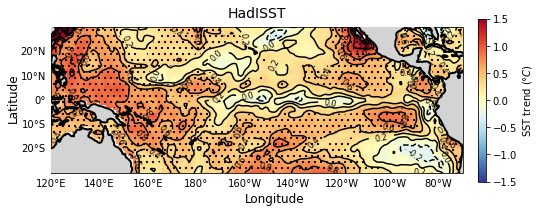

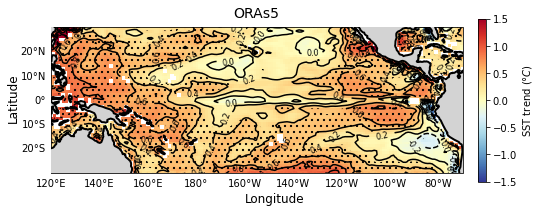

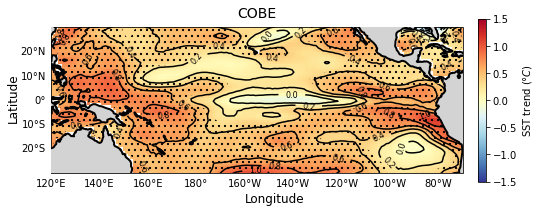

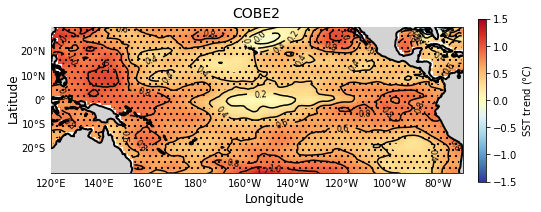

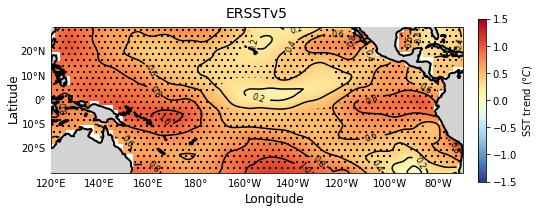

In [37]:
os.system('mkdir trends-TP')
os.system('mkdir data-TP')

for prod in prods:
    print(prod)
    file = f'data-TP/{prod}_ts.nc'
    if os.path.exists(file):
        ds = xr.open_dataset(file)
    else:
        ds = load_dataset(urls[prod],start[prod])
        ds = ds.sel(time=slice('1958-01','2018-12')).coarsen(time=12,boundary='trim').mean()
        regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=False)
        dsr = regridder(ds)
        dsr.to_netcdf(file,encoding=encoding)
        ds = dsr
   
    ds_stats = linregress_xr(ds.ts)
    plot_TP(ds_stats,prod)
    
    ds_stats.to_netcdf(f'trends-TP/{prod}_ts.nc')

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


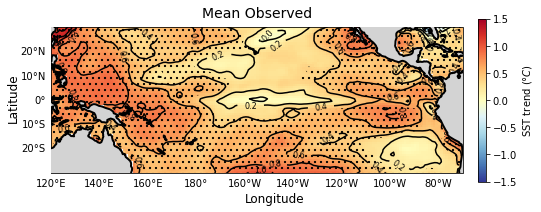

In [36]:
tfiles = [f'data-TP/{prod}_ts.nc' for prod in prods]
ds = [xr.open_dataset(file) for file in tfiles]
dsm = xr.concat(ds,dim='prod').mean('prod')
ds_stats = linregress_xr(dsm.ts)
plot_TP(ds_stats,'Mean')
ds_stats.to_netcdf(f'trends-TP/Mean_ts.nc')

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


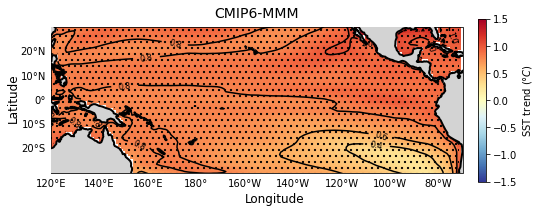

In [40]:
file = 'data-TP/CMIP6-MMM_ts.nc'
ds = xr.open_dataset(file)

ds_stats = linregress_xr(ds.ts)
plot_TP(ds_stats,'CMIP6-MMM')

ds_stats.to_netcdf('trends-TP/CMIP6-MMM_ts.nc')

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``outpu

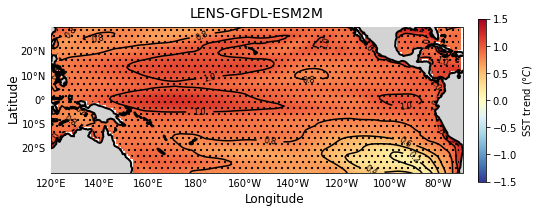

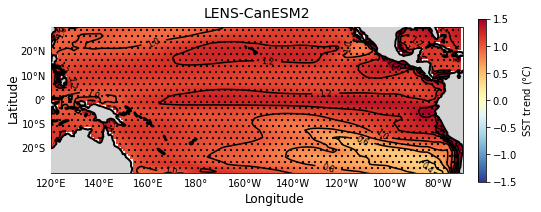

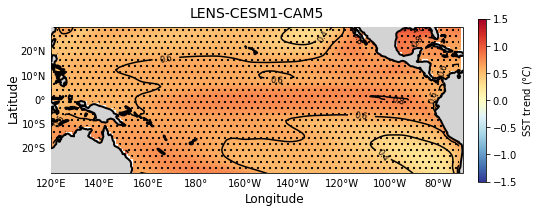

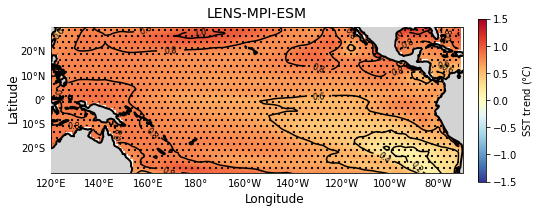

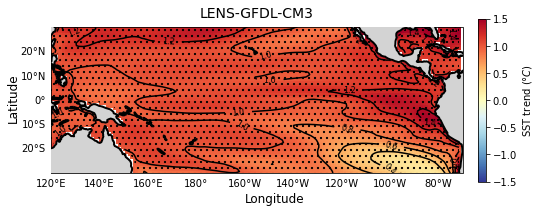

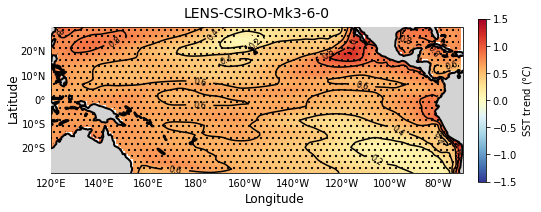

In [41]:
files = ['data-TP/LENS-GFDL-ESM2M_ts.nc', 'data-TP/LENS-CanESM2_ts.nc', 'data-TP/LENS-CESM1-CAM5_ts.nc',\
         'data-TP/LENS-MPI-ESM_ts.nc', 'data-TP/LENS-GFDL-CM3_ts.nc', 'data-TP/LENS-CSIRO-Mk3-6-0_ts.nc']

for file in files:
    name = file.split('data-TP/')[-1].split('_ts.nc')[0]
    ds = xr.open_dataset(file)
    assert len(ds.time) == 61
    
    ds_stats = linregress_xr(ds.ts)
    plot_TP(ds_stats,name)
    ds_stats.to_netcdf(f'trends-TP/{name}_ts.nc')

['data-TP/LENS-GFDL-ESM2M_ts.nc', 'data-TP/LENS-CanESM2_ts.nc', 'data-TP/LENS-CESM1-CAM5_ts.nc', 'data-TP/LENS-MPI-ESM_ts.nc', 'data-TP/LENS-GFDL-CM3_ts.nc', 'data-TP/LENS-CSIRO-Mk3-6-0_ts.nc']
data-TP/LENS-GFDL-ESM2M_ts.nc Frozen(SortedKeysDict({'time': 61, 'lat': 62, 'lon': 172}))
data-TP/LENS-CanESM2_ts.nc Frozen(SortedKeysDict({'time': 61, 'lat': 62, 'lon': 172}))
data-TP/LENS-CESM1-CAM5_ts.nc Frozen(SortedKeysDict({'time': 61, 'lat': 62, 'lon': 172}))
data-TP/LENS-MPI-ESM_ts.nc Frozen(SortedKeysDict({'time': 61, 'lat': 62, 'lon': 172}))
data-TP/LENS-GFDL-CM3_ts.nc Frozen(SortedKeysDict({'time': 61, 'lat': 62, 'lon': 172}))
data-TP/LENS-CSIRO-Mk3-6-0_ts.nc Frozen(SortedKeysDict({'time': 61, 'lat': 62, 'lon': 172}))


/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  from ipykernel import kernelapp as app


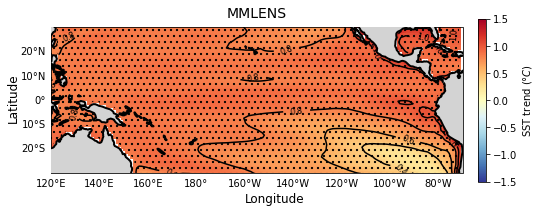

In [42]:
files = ['data-TP/LENS-GFDL-ESM2M_ts.nc', 'data-TP/LENS-CanESM2_ts.nc', 'data-TP/LENS-CESM1-CAM5_ts.nc',\
         'data-TP/LENS-MPI-ESM_ts.nc', 'data-TP/LENS-GFDL-CM3_ts.nc', 'data-TP/LENS-CSIRO-Mk3-6-0_ts.nc']
time = xr.open_dataset(files[0]).time

dss = []
for file in files:
    ds = xr.open_dataset(file)
    ds['time'] = time
    dss += [ds]

ds_LENS = xr.concat(dss,dim='model').mean('model')
assert len(ds_LENS.time) == 61

name = 'MMLENS'
ds_stats = linregress_xr(ds_LENS.ts)
plot_TP(ds_stats,name)
ds_stats.to_netcdf(f'trends-TP/{name}_ts.nc')